<a href="https://colab.research.google.com/github/kpjaskie/Positive_Unlabeled/blob/main/Simple_MLR_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Positive Unlabeled Learning using MLR (Modified Logistic Regression) 
This is a straightforward and non-optimized implementation of the MLR algorithm
described in [1].  This version has not yet been vectorized and as such is 
rather slow, but effective for demonstrating proof of concept.  

First, some definitions:


> $X$ = the dataset with each row being a data sample and each column representing a feature

> $y\in\{0,1\}$ = the true binary labels for dataset $X$ 

> $s\in\{0,1\}$ = represents whether or not a data sample is labeled or not


The example problem provided here uses any two chosen digits of the MNIST dataset with any choice of c values.  In this implementation, 
$$c=p(s=1|y=1)$$

The likelihood is calculated using the $p(s=1|x)$ and $p(s=0|x)$ shown in [1], partial derivitives are calculated, and a standard gradient ascent algorithm is used.  Currently regularization has not been incorporated though it needs to be added at some point.

## References
[1] K. Jaskie, C. Elkan, and A. Spanias, “A Modified Logistic Regression for Positive and Unlabeled Learning,” in IEEE Asilomar, Pacific Grove, California, pp. 0–5, Nov. 2019.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot
import math
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
import warnings

In [2]:
#@title MLR Functions
def MLR_fit(X, s, epochs, learning_rate):
  n, m = X.shape

  #Shuffle data
  X, s = shuffle(X, s)

  #Normalize data
  X, mean, normRange = normalize_data(X) 

  #Add a column of ones
  X = np.concatenate((np.ones((n, 1)), X), axis=1)

  feature_weights = np.ones((1, m+1))
  b = 1  

  for i in range(epochs):
    #shuffle data for this epoch
    X, s = shuffle(X, s)

    #Cycle through each datasample (need to vectorize!)
    for t in range(n):
      #Calculate partial derivative components
      e_w = np.exp(np.dot(-feature_weights, X[t,:].T))
      d1 = b*b + e_w
      d2 = 1 + d1

      if math.isinf(e_w):
          dw = np.zeros_like(X[t,:]) 
      else:
          dw = ((s[t] - 1)/d1 + 1/d2) * X[t,:] * e_w
      
      db = ((1 - s[t])/d1 - 1/d2) * 2 * b

      feature_weights = feature_weights + learning_rate * dw 
      b = b + learning_rate * db

  #Estimate c=p(s=1|y=1) using learned b value
  c_hat = np.divide(1, (1 + b*b))

  return b, c_hat, feature_weights, mean, normRange

def MLR_predict(X, feature_weights, b, c_hat, mean, normRange):
  n, m = X.shape

  X = np.concatenate((np.ones((n, 1)), X), axis=1)

  mean = np.concatenate(([0], mean))
  normRange = np.concatenate(([1], normRange))

  normalizedSample = (X - mean)/normRange 
  normalizedSample = np.nan_to_num(normalizedSample, nan=0.0, posinf=0.0, neginf=0.0)

  e_w = np.exp(np.dot(-normalizedSample, np.transpose(feature_weights)))
  e_w = np.nan_to_num(e_w, nan=0.0, posinf=0.0, neginf=0.0)

  s_hat = 1. / (1 + b*b + e_w)
  y_hat = s_hat / c_hat

  return y_hat

def MLR(X, y, s, epochs, learning_rate):
  b, c_hat, feature_weights, mean, normRange = MLR_fit(X, s, epochs, learning_rate)
  y_hat = MLR_predict(X, feature_weights, b, c_hat, mean, normRange)

  stats = evaluate(y, y_hat, s)

  return stats

In [10]:
#@title Load MNIST Dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist

def load_MNIST_data(display = False):  
  #@markdown Select positive and negative classes:
  Positive_class = '3' #@param ["0","1","2","3","4","5","6","7","8","9"]
  Negative_class = '5' #@param ["0","1","2","3","4","5","6","7","8","9"]
  assert Positive_class is not Negative_class, \
        "Positive and negative sets must be different"
  digit_P = int(Positive_class)
  digit_N = int(Negative_class)

  #Load entire data set
  (x_train_all, y_train_all),(x_test_all, y_test_all) = mnist.load_data()

  #combine data for PU problem
  X_orig = x_train_all 
  y_orig = y_train_all 

  #isolate desired digits
  X_P = X_orig[y_orig == digit_P,:,:]
  X_N = X_orig[y_orig == digit_N,:,:]

  y_P = np.ones((X_P.shape[0], 1))
  y_N = np.zeros((X_N.shape[0],1))

  if(display is True):
    print("\nSome images from the positive and negative sets: ")
    show_MNIST_images(X_P)
    show_MNIST_images(X_N)
  
  X_P = X_P.reshape(X_P.shape[0], X_P.shape[1]*X_P.shape[2])
  X_N = X_N.reshape(X_N.shape[0], X_N.shape[1]*X_N.shape[2])

  #Combine 
  X = np.concatenate((X_P, X_N))
  y = np.concatenate((y_P, y_N))
  X, y = shuffle(X, y)

  return X, y, digit_P, digit_N

def show_MNIST_images(images):
  # visualize random 2x4 subset of images
  nrows = 2
  ncols = 4

  # Set up matplotlib fig, and size it to fit 
  fig = plt.gcf()
  fig.set_size_inches(ncols * 3, nrows * 3)

  # choose random images to display
  for i in range(nrows * ncols):
    pic_index = random.randint(0, len(images)-1)
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    plt.imshow(images[pic_index])

  plt.show()  

In [14]:
#@title Helper Functions
# Take data, labels, and the c value and simulate PU dataset
def convert_to_PU(X, y, c): 
  n, m = X.shape
  pos_size = int(c * np.sum(y))
  
  #Separate positive and negative data
  y_reshaped = y.reshape(y.shape[0])

  pos_mask = y_reshaped == 1;
  neg_mask = y_reshaped == 0;

  pos = X[pos_mask,:]
  neg = X[neg_mask,:]

  #Shuffle pos and neg before dividing them up 
  pos = shuffle(pos)
  neg = shuffle(neg)

  P = pos[0:pos_size,:]
  Q = pos[pos_size:,:]
  N = neg

  U = np.concatenate((Q, N))

  X = np.concatenate((P, U))
  y = np.concatenate((np.ones((pos.shape[0], 1)), np.zeros((neg.shape[0], 1))))
  s = np.concatenate((np.ones((P.shape[0],1)), np.zeros((U.shape[0],1))))

  #Shuffle again 
  X, y, s = shuffle(X, y, s)

  return X, y, s

#Use common evaluation metrics to evaluate predictions
def evaluate(y, y_hat, s):
    y_hat_bin = (y_hat >= 0.5)*1  #This threshold could be adjusted
    CM = confusion_matrix(y, y_hat_bin)

    accuracy = accuracy_score(y, y_hat_bin)
    recall = recall_score(y, y_hat_bin)
    precision = precision_score(y, y_hat_bin)
    fscore = f1_score(y, y_hat_bin)
    mcc = matthews_corrcoef(y, y_hat_bin)

    return accuracy, fscore, recall, precision, mcc

#Shuffle arrays together in sync (I'm sure there's a better way to do this)
empty = np.zeros((0,0))
def shuffle(x, y=empty, z=empty):
  order = np.random.permutation(x.shape[0])
  x_shuffled = x[order,:]
  y_flag = False
  z_flag = False

  if y.shape[0] > 0:
    assert y.shape[0] == x.shape[0], 'Arrays must have the same length.'
    y_shuffled = y[order,:]
    y_flag = True

  if z.shape[0] > 0:
    assert z.shape[0] == x.shape[0], 'Arrays must have the same length.'
    z_shuffled = z[order,:]
    z_flag = True

  #Accomodate different number of outputs
  if y_flag and z_flag:
    return x_shuffled, y_shuffled, z_shuffled
  elif y_flag and not z_flag:
    return x_shuffled, y_shuffled
  elif not y_flag and not z_flag:
    return x_shuffled

#Min/max normalization of data
def normalize_data(data):  #Assumes columns = features and rows = samples
  mean = np.mean(data, axis=0)  
  normRange = np.max(data, axis=0) - np.min(data, axis=0) #np.std(data, axis=0)

  norm = np.true_divide((data - mean), normRange)
    
  # to handle the situation where the the denominator equals zero after 
  # normalization in some columns, convert the resulting NaNs to 0s
  norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)

  return norm, mean, normRange


Some images from the positive and negative sets: 


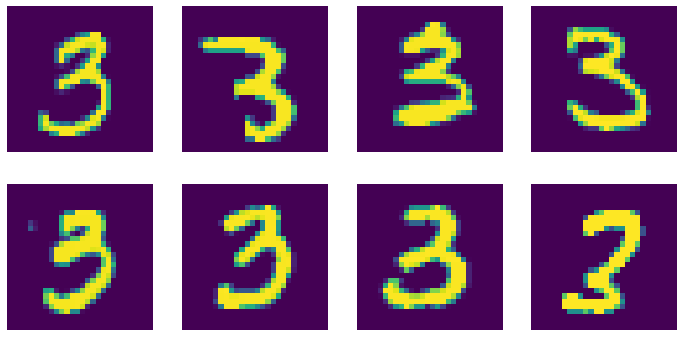

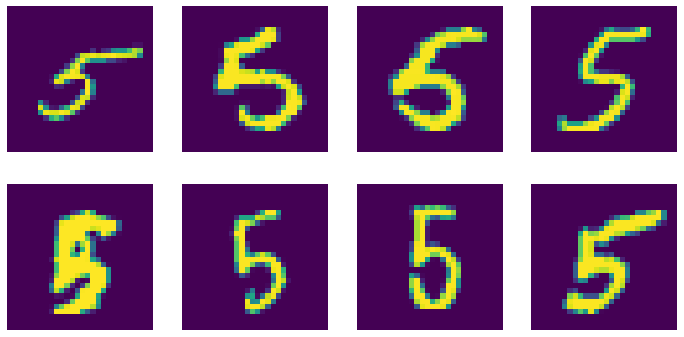

c =  0.1
c =  0.5
c =  0.9


,c,Accuracy,F-score,Precision,Recall,MCC,epochs,learning_rate
0,0.1,0.872230,0.867623,0.963738,0.788941,0.760500,1000.0,0.01
1,0.1,0.871451,0.865745,0.971197,0.780949,0.761541,1000.0,0.01
2,0.1,0.871970,0.866142,0.972956,0.780460,0.762961,1000.0,0.01
3,0.5,0.948667,0.950513,0.973172,0.928886,0.898301,1000.0,0.01
4,0.5,0.950398,0.952142,0.975693,0.929702,0.901858,1000.0,0.01
5,0.5,0.956891,0.958754,0.973919,0.944055,0.914114,1000.0,0.01
6,0.9,0.975762,0.977214,0.975150,0.979286,0.951336,1000.0,0.01
7,0.9,0.975935,0.977362,0.975931,0.978796,0.951683,1000.0,0.01
8,0.9,0.978705,0.980045,0.974827,0.985321,0.957281,1000.0,0.01


In [23]:
#@title Run MLR Algorithm

#In several places the program gets a runtime warning for dividing by zero,
#but the problem is then handled in the code.  So warnings are disabled.
warnings.filterwarnings("ignore")  

#@markdown ##Experiment Parameters
C_vals = '0.1, 0.5, 0.9' #@param["0.5", "0.1, 0.5, 0.9", "0.1, 0.2, ..., 0.9", "custom"]
num_runs =  3#@param {type:"integer"}

if C_vals == '0.5':
    c_vals = [0.5]
elif C_vals == '0.1, 0.5, 0.9':
    c_vals = [0.1, 0.5, 0.9]
elif C_vals == '0.1, 0.2, ..., 0.9':
    c_vals = np.arange(0.1, 1, 0.1).tolist()
elif C_vals == 'custom': #Enter whatever you want here
    c_vals = [0.01, 0.02]

#@markdown ##Hyperparameters
epochs =  1000#@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}

X, y, P_class, N_class = load_MNIST_data(display = True)

results = pd.DataFrame(columns=['c', 'Accuracy', 'F-score', 
                                  'Precision', 'Recall', 'MCC', 
                                  'epochs', 'learning_rate'])
#Run tests
for c in c_vals:
  print('c = ', c)
  
  for r in range(num_runs):
    #Randomly select subsets to be known and unknown
    X_loop, y_loop, s_loop = convert_to_PU(X, y, c)
    stats = MLR(X_loop, y_loop, s_loop, epochs, learning_rate)

    test_stats = {'c':c, 'Accuracy': stats[0],'F-score': stats[1], 
                  'Recall': stats[2], 'Precision': stats[3], 'MCC':stats[4], 
                  'epochs': epochs, 'learning_rate': learning_rate}

    results = results.append(test_stats, ignore_index=True)

#Plot final results
results